In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set paths (Windows format)
BASE_PATH = r'../data/raw/building-data-genome-project-2/data'

print(f"Base path: {BASE_PATH}")
print(f"Path exists: {os.path.exists(BASE_PATH)}")

Base path: ../data/raw/building-data-genome-project-2/data
Path exists: True


In [ ]:
# Load metadata
metadata_path = os.path.join(BASE_PATH, 'metadata/metadata.csv')
metadata = pd.read_csv(metadata_path)

print(f"Metadata shape: {metadata.shape}")
print(f"\nBuilding types:")
print(metadata['primaryspaceusage'].value_counts())
print(f"\nSites:")
print(metadata['site_id'].value_counts())
print(f"\nFirst few rows:")
print(metadata.head())

✅ Metadata shape: (1636, 32)

Building types:
primaryspaceusage
Education                        617
Office                           307
Entertainment/public assembly    204
Lodging/residential              168
Public services                  166
Other                             29
Healthcare                        29
Parking                           24
Warehouse/storage                 15
Manufacturing/industrial          13
Retail                            12
Services                          11
Technology/science                 7
Food sales and service             6
Utility                            4
Religious worship                  3
Name: count, dtype: int64

Sites:
site_id
Rat         305
Hog         163
Lamb        147
Fox         137
Panther     136
Cockatoo    124
Bull        124
Eagle       106
Bear         92
Gator        74
Robin        52
Peacock      47
Bobcat       36
Wolf         36
Swan         21
Moose        15
Shrew         9
Mouse         7
Crow          

In [3]:
# Load electricity
electricity_path = os.path.join(BASE_PATH, 'meters/raw/electricity.csv')
electricity = pd.read_csv(electricity_path, index_col=0)
electricity.index = pd.to_datetime(electricity.index)

print(f"✅ Electricity shape: {electricity.shape}")
print(f"Date range: {electricity.index.min()} to {electricity.index.max()}")
print(f"Buildings: {electricity.shape[1]}")


✅ Electricity shape: (17544, 1578)
Date range: 2016-01-01 00:00:00 to 2017-12-31 23:00:00
Buildings: 1578


In [ ]:
# Check missing values
missing_pct = (electricity.isna().sum() / len(electricity)) * 100

print(f"Missing data statistics:")
print(f"Mean: {missing_pct.mean():.2f}%")
print(f"Median: {missing_pct.median():.2f}%")
print(f"Max: {missing_pct.max():.2f}%")
print(f"Min: {missing_pct.min():.2f}%")

# Filter good buildings
good_buildings = missing_pct[missing_pct < 20].index.tolist()
print(f"\nBuildings with <20% missing: {len(good_buildings)}")

Missing data statistics:
Mean: 4.74%
Median: 0.15%
Max: 100.00%
Min: 0.00%

✅ Buildings with <20% missing: 1474


In [ ]:
# Filter metadata for good buildings
# CORRECTED: Use 'building_id' instead of 'uid'
metadata_clean = metadata[metadata['building_id'].isin(good_buildings)]

# Sample strategy: diversity across types
np.random.seed(42)
sample_list = []

# Get top building types
# Check what the correct column name is for building type - might be 'primaryspaceusage' or 'primary_use'
print("Building types available:")
print(metadata_clean['primaryspaceusage'].value_counts() if 'primaryspaceusage' in metadata_clean.columns else metadata_clean.columns)

top_types = metadata_clean['primaryspaceusage'].value_counts().head(5).index
print(f"Top building types: {list(top_types)}")

for btype in top_types:
    buildings = metadata_clean[metadata_clean['primaryspaceusage'] == btype]
    n_sample = min(3, len(buildings))
    sample = buildings.sample(n=n_sample, random_state=42)
    sample_list.append(sample)
    print(f"{btype}: {n_sample} buildings selected")

selected_metadata = pd.concat(sample_list).head(15)
selected_ids = selected_metadata['building_id'].tolist()  # Also change here

print(f"\nSelected {len(selected_ids)} buildings:")
print(selected_metadata[['building_id', 'primaryspaceusage', 'sqm', 'site_id']])  # Adjust column names

# Save selection
selected_metadata.to_csv('../data/processed/selected_buildings.csv', index=False)
print(f"\nSaved to: ../data/processed/selected_buildings.csv")

Building types available:
primaryspaceusage
Education                        561
Office                           282
Entertainment/public assembly    193
Public services                  154
Lodging/residential              147
Healthcare                        26
Other                             25
Parking                           22
Warehouse/storage                 14
Retail                            11
Manufacturing/industrial          11
Services                           9
Technology/science                 6
Food sales and service             6
Utility                            4
Religious worship                  3
Name: count, dtype: int64
Top building types: ['Education', 'Office', 'Entertainment/public assembly', 'Public services', 'Lodging/residential']
Education: 3 buildings selected
Office: 3 buildings selected
Entertainment/public assembly: 3 buildings selected
Public services: 3 buildings selected
Lodging/residential: 3 buildings selected

✅ Selected 15 buildings:


✅ Saved visualization


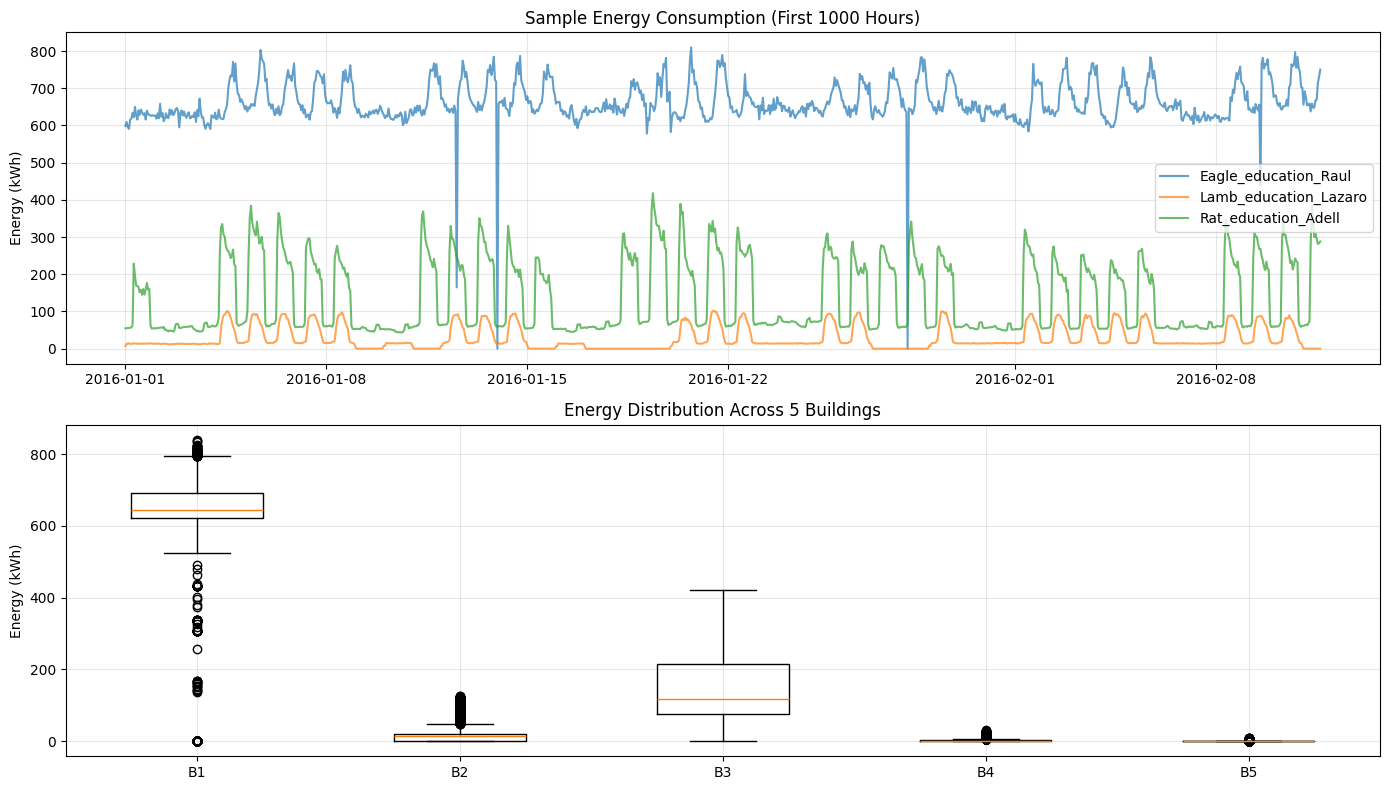

In [ ]:
# Plot 1: Time series for 3 buildings
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

for i, bid in enumerate(selected_ids[:3]):
    axes[0].plot(electricity[bid].iloc[:1000], label=bid, alpha=0.7)

axes[0].set_title('Sample Energy Consumption (First 1000 Hours)')
axes[0].set_ylabel('Energy (kWh)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Distribution
data_to_plot = [electricity[bid].dropna().values for bid in selected_ids[:5]]
axes[1].boxplot(data_to_plot)
axes[1].set_title('Energy Distribution Across 5 Buildings')
axes[1].set_ylabel('Energy (kWh)')
axes[1].set_xticklabels([f'B{i+1}' for i in range(5)])
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/01_data_exploration.png', dpi=300)
print("Saved visualization")
plt.show()